Implements raster and vector analysis using the TI-City model results and its spatial inputs.

### Authorship
@author: Alexandre Pereira Santos <br>
alexandre.santos(at)lmu.de<br>
- uses OSMNx, pandas, geopandas, rasterio
- may include content from ChatGPT or GitHub Copilot

### Features
1. Calculate Moran I's spatial autocorrelation in a stepwise configuration
2. 

# Imports

In [40]:
import pandas as pd
import geopandas as gpd

import os
from pathlib import Path
import fnmatch
import shutil

import numpy as np
import random 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from shapely.geometry.polygon import Polygon
from shapely.geometry import MultiLineString, LineString
import json

import rasterio
from rasterio.mask import mask
from rasterio.plot import show, show_hist, plotting_extent
from rasterio.warp import reproject, calculate_default_transform, Resampling
from rasterio.features import dataset_features

#from libpysal.weights import lat2W, Rook
#from esda.moran import Moran

# init

In [7]:
#input a vector and a raster file for each city
AOI_path = Path('../data/processed/')
MUM_file = 'MUM_LIM_reference_AOI_30m.shp' # APS: updated AOI 01.08.2024
MAN_file = 'MAN_LIM_reference_AOI_30m.shp' # APS: updated AOI 01.11.2024
JAK_file = 'JAK_LIM_reference_AOI_30m.shp' # APS: updated AOI 23.08.2024
#  the 'case_city' variable defines the city we are working on. APS: Need to update the code below to change it from MUM to the variable name

case_city = 'MAN' #MUM MAN JAK

if case_city == 'MUM':
    
    AOI_gdf = gpd.read_file(AOI_path / MUM_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/MUM_LIM_reference_AOI_30m.tif')
    ref_raster_150_path = Path('../data/processed/MUM_LIM_reference_AOI_150m.tif')
    

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\TIFF_150m\\')
    model_inputs_SLEUTH_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\TIFF_SLEUTH_150m')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\ASCII_150m')
    ascii150_SLEUTH_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\ASCII_SLEUTH_150m')
    ti_city_ascii_path = Path('../model/MUM/data/in/')
    ti_city_out_path = Path('../model/MUM/data/out/')
    ref_raster_sleuth_path = model_inputs_SLEUTH_150m_path / (case_city + '_URB_SLEUTH_input_2022.tif' )

    gadm_var = 'NAME_3'

if case_city == 'MAN':
    
    AOI_gdf = gpd.read_file(AOI_path / MAN_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/MAN_LIM_reference_AOI_30m.tif')
    ref_raster_150_path = Path('../data/processed/MAN_LIM_reference_AOI_150m.tif')

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\TIFF_150m\\')
    model_inputs_SLEUTH_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\TIFF_SLEUTH_150m')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\ASCII_150m')
    ascii150_SLEUTH_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\ASCII_SLEUTH_150m')
    ti_city_ascii_path = Path('../model/MAN/data/in/')
    ti_city_out_path = Path('../model/MAN/data/out/')
    ref_raster_sleuth_path = model_inputs_SLEUTH_150m_path / (case_city + '_URB_SLEUTH_input_2022.tif' )

    gadm_var = 'NAME_2'

if case_city == 'JAK':
    
    AOI_gdf = gpd.read_file(AOI_path / JAK_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/JAK_LIM_reference_AOI_30m.tif')
    ref_raster_150_path = Path('../data/processed/JAK_LIM_reference_AOI_150m.tif')

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\TIFF_150m\\')
    model_inputs_SLEUTH_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\TIFF_SLEUTH_150m')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\ASCII_150m')
    ascii150_SLEUTH_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\ASCII_SLEUTH_150m')
    ti_city_ascii_path = Path('../model/JAK/data/in/')
    ti_city_out_path = Path('../model/JAK/data/out/')
    ref_raster_sleuth_path = model_inputs_SLEUTH_150m_path / (case_city + '_URB_SLEUTH_input_2022.tif' )

    gadm_var = 'NAME_2'

external_data_path = Path(r'D:\\Dropbox\\x\\_data')
ascii150_arcgis_path = Path(r"D:\\Dropbox\\x\\PostDoc\ASCII_150m")

%run ./ti_city_00_raster_functions.ipynb

# read the reference raster
with rasterio.open(ref_raster_path,'r') as src:
    ref_raster = src
    ref_meta = src.meta
    ref_height, ref_width, ref_area = get_transform(ref_raster)



# suppress deprecation warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# 1. load ASCII results

In [89]:
std_path = '25 03 17 1128 027 std calib w RED on/expansion_income_2050.asc' 
ssp1_path = '25 03 17 2031 028 SSP1/expansion_income_2050.asc' 
ssp2_path = '25 03 17 2032 029 SSP2/expansion_income_2050.asc'
ssp3_path = '25 03 17 2055 030 SSP3/expansion_income_2050.asc'

# "D:\GIT\ti-city-model\model\MAN\data\out\25 03 17 1128 027 std calib w RED on\expansion_income_2050.asc"
agent_class_dict = {'na':0,'low': 1, 'mid': 2, 'high': 3, 'deprived': 4, 'urban_2022': 5}
results_path_dict = {'std': std_path, 'ssp1':ssp1_path, 'ssp2': ssp2_path, 'ssp3': ssp3_path}
results_list = ['std' ,'ssp1', 'ssp2', 'ssp3']

## if necessary, import ASCIIs and export them to TIFFs

In [ ]:

results_dict_ascii = {}
for result in results_list:
    path = results_path_dict[result]
    with rasterio.open(ti_city_out_path / path, 'r') as src:
        array = src.read(1)
        results_dict_ascii[result] = array

# export the results raster to TIFF, using the SLEUTH raster as reference
for key, value in results_dict_ascii.items():
    file_name = case_city + '_TI-City_results_' + key + '_2050.tif'
    export_raster(raster = value,
                  url = processed_path / file_name,
                  data_type=rasterio.int16,
                  ref_raster_path=ref_raster_sleuth_path
                  )

## Otherwise, import the TIFFs

In [90]:
# import the tiffs, with the correct reference raster
results_dict = {}
for result in results_list:
    key = result
    file_name = case_city + '_TI-City_results_' + key + '_2050.tif'
    with rasterio.open(processed_path / file_name, 'r') as src:
        array = src.read(1)
        results_dict[result] = array
        print(key, array.shape)

std (704, 533)
ssp1 (704, 533)
ssp2 (704, 533)
ssp3 (704, 533)


Unique values [0 1 2 3 4 5] 
Min value 0 , Type: int16


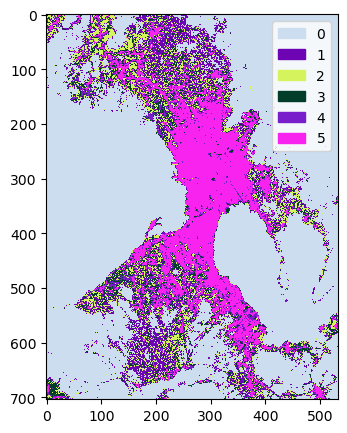

In [79]:
#fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(5,20))
%run ./ti_city_00_raster_functions.ipynb
from matplotlib.colors import LinearSegmentedColormap
plot_unique_value_raster(results_dict['ssp3']) #, colors=['#ffffff','#6eca74','#98ABF7','#414bb2','#f0a1c5','#dbdbce'])

# 2. import the regions for analysis

(704, 533)
Unique values [0 1 2 3] 
Min value 0 , Type: int16


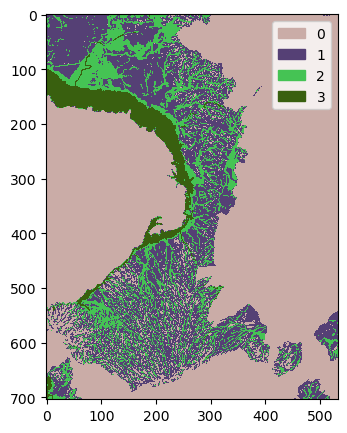

In [85]:
file_name = case_city + '_HYD_25_year_flooding_surgeSSA1_reclass_150m.tif'
exposure_areas_path = model_inputs_SLEUTH_150m_path / file_name

with rasterio.open(exposure_areas_path,'r') as src:
    exposure_raster = src.read(1)
    # we have to adjust the area of the exposure raster to that of the results
print(exposure_raster.shape)
plot_unique_value_raster(exposure_raster)
#plot_unique_value_raster(exposure_raster, title='Areas exposed to flooding (25 years return) and storm surge')

In [ ]:
file_name = case_city + '_HYD_25_year_flooding_surgeSSA1_reclass_150m.tif'
exposure_areas_path  = interim_path / file_name
ref_raster_sleuth_path
with rasterio.open(exposure_areas_path,'r') as src:
    src_array = src.read(1)
    # we have to adjust the area of the exposure raster to that of the results
    
    ref_array = results_dict_tiff['std']
    ref_bounds = results_dict_tiff['std'].bounds
    if src.crs == ref_raster.crs:
        bbox = [
            {
            'type': 'Polygon',
            'coordinates': [[
                [ref_bounds.left, ref_bounds.bottom],
                [ref_bounds.left, ref_bounds.top],
                [ref_bounds.right, ref_bounds.top],
                [ref_bounds.right, ref_bounds.bottom],
                [ref_bounds.left, ref_bounds.bottom]
                ]]
            }
        ]
        #print(bbox)
        try:
            exposure_raster, exposure_raster_transform = mask(src, bbox, crop=True)
            exposure_raster = exposure_raster[0]
            exposure_raster = exposure_raster.astype('int16')
        except ValueError:
            raise ValueError("The input raster does not intersect the reference raster.")
    else: print('CRS mismatch')
    #out_image, out_transform, out_meta = clip_raster_by_ref(exposure_areas_raster, ref_raster_sleuth_path)
    
print(exposure_raster.shape)
plot_unique_value_raster(exposure_raster, title='Areas exposed to flooding (25 years return) and storm surge')

In [ ]:
# import polygons for different city areas (e.g., municipalities in a metropolitan region)


# 3. Analysis

# 3.1 compile descriptive stats on the population for each SSP considering socioconomic profile and exposure

In [102]:
results_dict['std']

array([[5, 5, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       [5, 0, 5, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [150]:
# prepare one table for SSP1, SSP2, SSP3, and the standard scenario
# the table should contain the following columns:
# - total urban area (i.e., the number of cells with a value of 1 in the raster, times the cell area)
# - total urban area exposed to flooding and storm surge (i.e., the number of cells with a value of 1 in the raster, in any exposure class, times the cell area)
# - the urban area for the deprived class (i.e., the number of cells with a value of 1 in the raster, times the cell area, for the deprived class)
# - the urban area for the deprived class exposed to flooding and storm surge (i.e., the number of cells with a value of 1 in the raster, in any exposure class, times the cell area, for the deprived class)
# the same for the other classes
import pandas as pd
import numpy as np

# Define cell area (in square meters, for example)
cell_area = 0.150 * 0.150  # Assuming 150m x 150m cells,and returning area in square km

# Initialize a DataFrame to store the results
columns = [
    "Scenario",
    "Total Urban Area",
    "Urban Area Exposed to Flooding",
    "Urban Area (Deprived)",
    "Urban Area Exposed (Deprived)",
    "Urban Area (Low)",
    "Urban Area Exposed (Low)",
    "Urban Area (Mid)",
    "Urban Area Exposed (Mid)",
    "Urban Area (High)",
    "Urban Area Exposed (High)"
]

agent_class_dict = {'na':0,'low': 1, 'mid': 2, 'high': 3, 'deprived': 4, 'urban_2022': 5}
agent_color_dict = {'low': '#6eca74', 'mid': '#98ABF7', 'high': '#414bb2', 'deprived': '#f0a1c5', 'urban_2022': '#dbdbce'}
#colors=['#ffffff','#6eca74','#98ABF7','#414bb2','#f0a1c5','#dbdbce']
descriptive_dict = {}
# Iterate through each scenario
for scenario, raster in results_dict.items():
    # Total urban area (all classes except 'na')
    stats_dict = {}
    stats_dict['Total Urban Area'] = np.round(np.sum(raster > 0) * cell_area, 2)
    # Total urban area exposed to flooding (any exposure class)
    stats_dict['Urban Area Exposed to Flooding'] = np.round(np.sum((raster > 0) & (exposure_raster > 0)) * cell_area, 2)

    stats_dict['Total New Urban Area'] = np.round(stats_dict['Total Urban Area'] - (np.sum(raster == agent_class_dict['urban_2022']) * cell_area), 2)
    stats_dict['New Urban Area Exposed to Flooding'] = np.round(stats_dict['Urban Area Exposed to Flooding'] - (np.sum((raster == agent_class_dict['urban_2022']) & (exposure_raster > 0)) * cell_area), 2)

    # Calculate urban area and exposed area for each class
    stats_dict['Urban Area (Deprived)'] = np.round(np.sum(raster == agent_class_dict['deprived']) * cell_area, 2)
    stats_dict['Urban Area Exposed (Deprived)'] = np.round(np.sum((raster == agent_class_dict['deprived']) & (exposure_raster > 0)) * cell_area, 2)

    stats_dict['Urban Area (Low)'] = np.round(np.sum(raster == agent_class_dict['low']) * cell_area, 2)
    stats_dict['Urban Area Exposed (Low)'] = np.round(np.sum((raster == agent_class_dict['low']) & (exposure_raster > 0)) * cell_area, 2)

    stats_dict['Urban Area (Mid)'] = np.round(np.sum(raster == agent_class_dict['mid']) * cell_area, 2)
    stats_dict['Urban Area Exposed (Mid)'] = np.round(np.sum((raster == agent_class_dict['mid']) & (exposure_raster > 0)) * cell_area, 2)

    stats_dict['Urban Area (High)'] = np.round(np.sum(raster == agent_class_dict['high']) * cell_area, 2)
    stats_dict['Urban Area Exposed (High)'] = np.round(np.sum((raster == agent_class_dict['high']) & (exposure_raster > 0)) * cell_area, 2)

    # Append the results to the table
    descriptive_dict[scenario] = stats_dict

# Display the results table
results_table = pd.DataFrame.from_dict(descriptive_dict, orient='index')
results_table

# Export the results table to an Excel file
output_file = case_city + '_urban_exposed_areas_analysis.xlsx'
results_table.to_excel(output_file, index_label="Scenario")
print(f"Results table exported to {output_file}")



Results table exported to MAN_urban_exposed_areas_analysis.xlsx


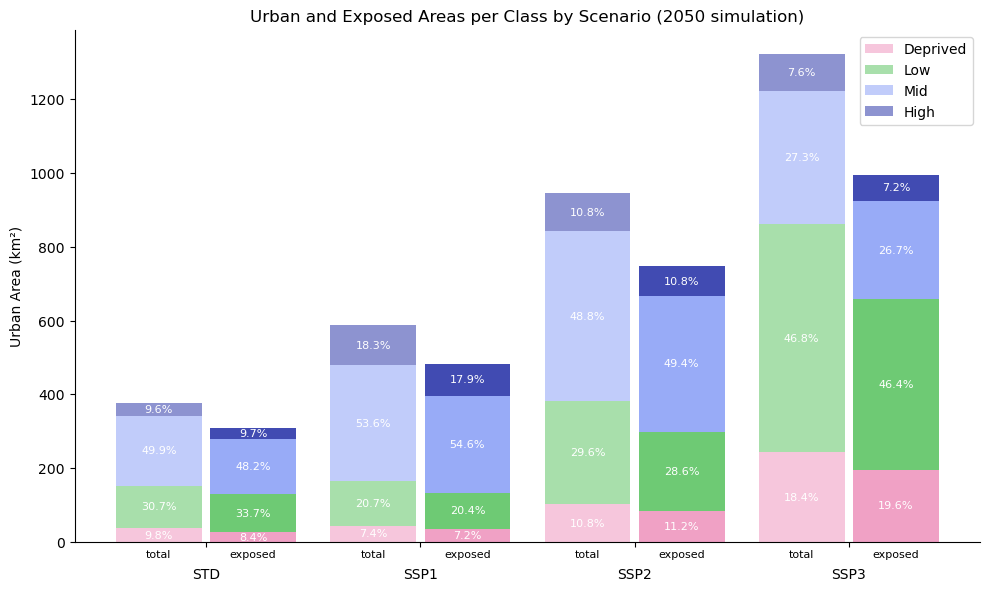

In [148]:
# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4

# Extract data for the stacked bar chart
scenarios = results_table.index.tolist()
urban_area_deprived = results_table["Urban Area (Deprived)"].values
urban_area_low = results_table["Urban Area (Low)"].values
urban_area_mid = results_table["Urban Area (Mid)"].values
urban_area_high = results_table["Urban Area (High)"].values

# Extract data for the exposed areas
urban_exposed_deprived = results_table["Urban Area Exposed (Deprived)"].values
urban_exposed_low = results_table["Urban Area Exposed (Low)"].values
urban_exposed_mid = results_table["Urban Area Exposed (Mid)"].values
urban_exposed_high = results_table["Urban Area Exposed (High)"].values

# Normalize the data to percentages
urban_area_total = urban_area_deprived + urban_area_low + urban_area_mid + urban_area_high
urban_area_deprived_percentage = (urban_area_deprived / urban_area_total) * 100
urban_area_low_percentage = (urban_area_low / urban_area_total) * 100
urban_area_mid_percentage = (urban_area_mid / urban_area_total) * 100
urban_area_high_percentage = (urban_area_high / urban_area_total) * 100

# Normalize the exposed data to percentages
urban_exposed_total = urban_exposed_deprived + urban_exposed_low + urban_exposed_mid + urban_exposed_high
urban_exposed_deprived_percentage = (urban_exposed_deprived / urban_exposed_total) * 100
urban_exposed_low_percentage = (urban_exposed_low / urban_exposed_total) * 100
urban_exposed_mid_percentage = (urban_exposed_mid / urban_exposed_total) * 100
urban_exposed_high_percentage = (urban_exposed_high / urban_exposed_total) * 100


# Adjust the x positions for the second set of bars
x_positions = np.arange(len(scenarios))
x_positions_exposed = x_positions + bar_width * 1.1

# Plot each class as a stack
p1 = ax.bar(scenarios, urban_area_deprived, bar_width, label="Deprived")
p2 = ax.bar(scenarios, urban_area_low, bar_width, bottom=urban_area_deprived, label="Low")
p3 = ax.bar(scenarios, urban_area_mid, bar_width, bottom=urban_area_deprived + urban_area_low, label="Mid")
p4 = ax.bar(scenarios, urban_area_high, bar_width, bottom=urban_area_deprived + urban_area_low + urban_area_mid, label="High")

# Use the colors from agent_color_dict
colors = [agent_color_dict['deprived'], agent_color_dict['low'], agent_color_dict['mid'], agent_color_dict['high']]

# Apply colors to all bars in each stack with reduced alpha
alpha_decay = 0.6
for bar, color in zip(p1, [colors[0]] * len(p1)):
    bar.set_facecolor(color)
    bar.set_alpha(alpha_decay)
for bar, color in zip(p2, [colors[1]] * len(p2)):
    bar.set_facecolor(color)
    bar.set_alpha(alpha_decay)
for bar, color in zip(p3, [colors[2]] * len(p3)):
    bar.set_facecolor(color)
    bar.set_alpha(alpha_decay)
for bar, color in zip(p4, [colors[3]] * len(p4)):
    bar.set_facecolor(color)
    bar.set_alpha(alpha_decay)

# Plot the exposed areas as a second series of bars
p5 = ax.bar(x_positions_exposed, urban_exposed_deprived, bar_width) #, label="Exposed (Deprived)"
p6 = ax.bar(x_positions_exposed, urban_exposed_low, bar_width, bottom=urban_exposed_deprived)#, label="Exposed (Low)")
p7 = ax.bar(x_positions_exposed, urban_exposed_mid, bar_width, bottom=urban_exposed_deprived + urban_exposed_low) #, label="Exposed (Mid)")
p8 = ax.bar(x_positions_exposed, urban_exposed_high, bar_width, bottom=urban_exposed_deprived + urban_exposed_low + urban_exposed_mid)#, label="Exposed (High)")

# Apply colors to the exposed bars
for bar, color in zip(p5, [colors[0]] * len(p5)):
    bar.set_facecolor(color)
for bar, color in zip(p6, [colors[1]] * len(p6)):
    bar.set_facecolor(color)
for bar, color in zip(p7, [colors[2]] * len(p7)):
    bar.set_facecolor(color)
for bar, color in zip(p8, [colors[3]] * len(p8)):
    bar.set_facecolor(color)

# Add 'total' label under the total urban area bars
for xpos, label in zip(x_positions, scenarios):
    ax.text(xpos, -35, 'total', ha='center', va='center', fontsize=8, color='black')

# Add 'exposed' label under the exposed area bars
for xpos, label in zip(x_positions_exposed, scenarios):
    ax.text(xpos, -35, 'exposed', ha='center', va='center', fontsize=8, color='black')

# Add percentages for each class inside the corresponding area of the graph
for i, scenario in enumerate(scenarios):
    # Total urban area percentages
    ax.text(x_positions[i], urban_area_deprived[i] / 2, f"{urban_area_deprived_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')
    ax.text(x_positions[i], urban_area_deprived[i] + urban_area_low[i] / 2, f"{urban_area_low_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')
    ax.text(x_positions[i], urban_area_deprived[i] + urban_area_low[i] + urban_area_mid[i] / 2, f"{urban_area_mid_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')
    ax.text(x_positions[i], urban_area_deprived[i] + urban_area_low[i] + urban_area_mid[i] + urban_area_high[i] / 2, f"{urban_area_high_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')

    # Exposed urban area percentages
    ax.text(x_positions_exposed[i], urban_exposed_deprived[i] / 2, f"{urban_exposed_deprived_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')
    ax.text(x_positions_exposed[i], urban_exposed_deprived[i] + urban_exposed_low[i] / 2, f"{urban_exposed_low_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')
    ax.text(x_positions_exposed[i], urban_exposed_deprived[i] + urban_exposed_low[i] + urban_exposed_mid[i] / 2, f"{urban_exposed_mid_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')
    ax.text(x_positions_exposed[i], urban_exposed_deprived[i] + urban_exposed_low[i] + urban_exposed_mid[i] + urban_exposed_high[i] / 2, f"{urban_exposed_high_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')

# Adjust x-axis ticks and labels
ax.set_xticks(x_positions + bar_width * 1.1 / 2)
ax.set_xticklabels([label.upper() for label in scenarios], y=-0.03)
# Add labels, title, and legend
#ax.set_xlabel("Scenario", fontsize=12)
ax.set_ylabel("Urban Area (km²)")
ax.set_title("Urban and Exposed Areas per Class by Scenario (2050 simulation)")
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

In [149]:
# Save the figure as a PNG file with 300 dpi
file_name = case_city + '_urban_exposed_areas.png'
fig.savefig(file_name, dpi=300, format="png", bbox_inches="tight")


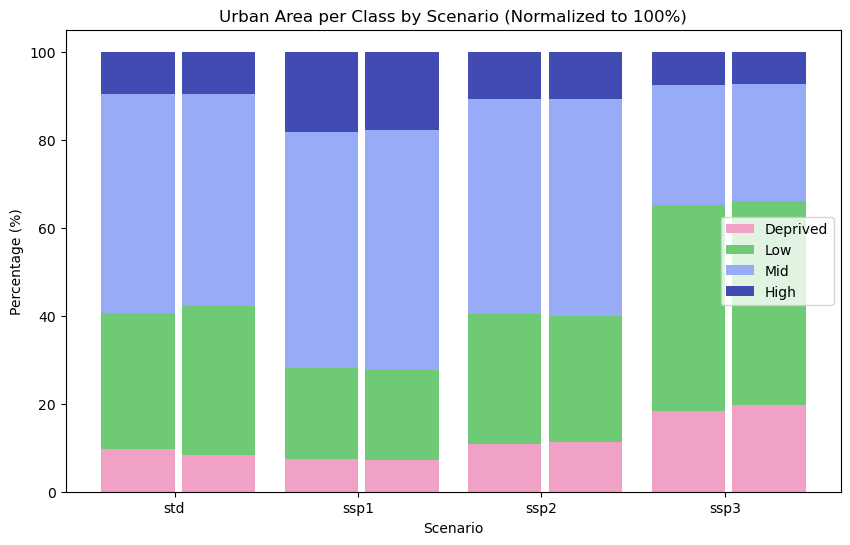

In [ ]:
# Normalize the data to percentages for stacked bars
urban_area_deprived_percentage = (urban_area_deprived / urban_area_total) * 100
urban_area_low_percentage = (urban_area_low / urban_area_total) * 100
urban_area_mid_percentage = (urban_area_mid / urban_area_total) * 100
urban_area_high_percentage = (urban_area_high / urban_area_total) * 100

urban_exposed_deprived_percentage = (urban_exposed_deprived / urban_exposed_total) * 100
urban_exposed_low_percentage = (urban_exposed_low / urban_exposed_total) * 100
urban_exposed_mid_percentage = (urban_exposed_mid / urban_exposed_total) * 100
urban_exposed_high_percentage = (urban_exposed_high / urban_exposed_total) * 100

# Plot each class as a stack normalized to 100%
p1 = ax.bar(scenarios, urban_area_deprived_percentage, bar_width, label="Deprived")
p2 = ax.bar(scenarios, urban_area_low_percentage, bar_width, bottom=urban_area_deprived_percentage, label="Low")
p3 = ax.bar(scenarios, urban_area_mid_percentage, bar_width, bottom=urban_area_deprived_percentage + urban_area_low_percentage, label="Mid")
p4 = ax.bar(scenarios, urban_area_high_percentage, bar_width, bottom=urban_area_deprived_percentage + urban_area_low_percentage + urban_area_mid_percentage, label="High")

# Plot the exposed areas as a second series of bars normalized to 100%
p5 = ax.bar(x_positions_exposed, urban_exposed_deprived_percentage, bar_width)
p6 = ax.bar(x_positions_exposed, urban_exposed_low_percentage, bar_width, bottom=urban_exposed_deprived_percentage)
p7 = ax.bar(x_positions_exposed, urban_exposed_mid_percentage, bar_width, bottom=urban_exposed_deprived_percentage + urban_exposed_low_percentage)
p8 = ax.bar(x_positions_exposed, urban_exposed_high_percentage, bar_width, bottom=urban_exposed_deprived_percentage + urban_exposed_low_percentage + urban_exposed_mid_percentage)

# Adjust y-axis label to reflect percentages
ax.set_ylabel("Percentage (%)")
p2 = ax.bar(scenarios, urban_area_low, bar_width, bottom=urban_area_deprived, label="Low")
p3 = ax.bar(scenarios, urban_area_mid, bar_width, bottom=urban_area_deprived + urban_area_low, label="Mid")
p4 = ax.bar(scenarios, urban_area_high, bar_width, bottom=urban_area_deprived + urban_area_low + urban_area_mid, label="High")

# Use the colors from agent_color_dict
colors = [agent_color_dict['deprived'], agent_color_dict['low'], agent_color_dict['mid'], agent_color_dict['high']]

# Apply colors to all bars in each stack
for bar, color in zip(p1, [colors[0]] * len(p1)):
    bar.set_facecolor(color)
for bar, color in zip(p2, [colors[1]] * len(p2)):
    bar.set_facecolor(color)
for bar, color in zip(p3, [colors[2]] * len(p3)):
    bar.set_facecolor(color)
for bar, color in zip(p4, [colors[3]] * len(p4)):
    bar.set_facecolor(color)

# Plot the exposed areas as a second series of bars
p5 = ax.bar(x_positions_exposed, urban_exposed_deprived, bar_width) #, label="Exposed (Deprived)"
p6 = ax.bar(x_positions_exposed, urban_exposed_low, bar_width, bottom=urban_exposed_deprived)#, label="Exposed (Low)")
p7 = ax.bar(x_positions_exposed, urban_exposed_mid, bar_width, bottom=urban_exposed_deprived + urban_exposed_low) #, label="Exposed (Mid)")
p8 = ax.bar(x_positions_exposed, urban_exposed_high, bar_width, bottom=urban_exposed_deprived + urban_exposed_low + urban_exposed_mid)#, label="Exposed (High)")

# Apply colors to the exposed bars
for bar, color in zip(p5, [colors[0]] * len(p5)):
    bar.set_facecolor(color)
for bar, color in zip(p6, [colors[1]] * len(p6)):
    bar.set_facecolor(color)
for bar, color in zip(p7, [colors[2]] * len(p7)):
    bar.set_facecolor(color)
for bar, color in zip(p8, [colors[3]] * len(p8)):
    bar.set_facecolor(color)

# Add 'total' label under the total urban area bars
for xpos, label in zip(x_positions, scenarios):
    ax.text(xpos, -35, 'total', ha='center', va='center', fontsize=8, color='black')

# Add 'exposed' label under the exposed area bars
for xpos, label in zip(x_positions_exposed, scenarios):
    ax.text(xpos, -35, 'exposed', ha='center', va='center', fontsize=8, color='black')

# Add percentages for each class inside the corresponding area of the graph
for i, scenario in enumerate(scenarios):
    # Total urban area percentages
    ax.text(x_positions[i], urban_area_deprived_percentage[i] / 2, f"{urban_area_deprived_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')
    ax.text(x_positions[i], urban_area_deprived_percentage[i] + urban_area_low_percentage[i] / 2, f"{urban_area_low_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')
    ax.text(x_positions[i], urban_area_deprived_percentage[i] + urban_area_low_percentage[i] + urban_area_mid_percentage[i] / 2, f"{urban_area_mid_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')
    ax.text(x_positions[i], urban_area_deprived_percentage[i] + urban_area_low_percentage[i] + urban_area_mid_percentage[i] + urban_area_high_percentage[i] / 2, f"{urban_area_high_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')

    # Exposed urban area percentages
    ax.text(x_positions_exposed[i], urban_exposed_deprived_percentage[i] / 2, f"{urban_exposed_deprived_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')
    ax.text(x_positions_exposed[i], urban_exposed_deprived_percentage[i] + urban_exposed_low_percentage[i] / 2, f"{urban_exposed_low_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')
    ax.text(x_positions_exposed[i], urban_exposed_deprived_percentage[i] + urban_exposed_low_percentage[i] + urban_exposed_mid_percentage[i] / 2, f"{urban_exposed_mid_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')
    ax.text(x_positions_exposed[i], urban_exposed_deprived_percentage[i] + urban_exposed_low_percentage[i] + urban_exposed_mid_percentage[i] + urban_exposed_high_percentage[i] / 2, f"{urban_exposed_high_percentage[i]:.1f}%", ha='center', va='center', fontsize=8, color='white')

# Adjust x-axis ticks and labels
ax.set_xticks(x_positions + bar_width * 1.1 / 2)
ax.set_xticklabels([label.upper() for label in scenarios], y=-0.03)
# Add labels, title, and legend
#ax.set_xlabel("Scenario", fontsize=12)
ax.set_ylabel("Urban Area (km²)")
ax.set_title("Urban and Exposed Areas per Class by Scenario (2050 simulation)")
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

# 4. Export TIFFs as ASCIIs

In [51]:
%run ./ti_city_00_raster_functions.ipynb
raster_list = [raster for raster in os.listdir(model_inputs_SLEUTH_150m_path) if raster.endswith('.tif')]

for raster in raster_list: 
    file_name = str(raster.replace('.tif', '.asc'))
    export_path = ascii150_SLEUTH_path / file_name
    with rasterio.open(model_inputs_SLEUTH_150m_path/raster, 'r') as r:
        export_raster_to_ascii(raster_obj = r.read(1),                             
                            export_path = export_path, 
                            ref_raster_path = ref_raster_150_path,
                            raster_data_type=r.dtypes[0])
    print(str(export_path).split('\\')[-1], 'exported')
print('done')

MAN_DEM_slope_pct_TanDEM_X_150m.asc exported
MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc exported
MAN_HYD_water_distance_150m.asc exported
MAN_LIM_districts_GADM4_150m.asc exported
MAN_LIM_exclusion_layer_150m.asc exported
MAN_LIM_exclusion_SLEUTH_SSP1_150m.asc exported
MAN_LIM_exclusion_SLEUTH_SSP2_150m.asc exported
MAN_LIM_exclusion_SLEUTH_SSP3_150m.asc exported
MAN_LIM_non_residential_areas_150m.asc exported
MAN_LIM_reference_SLEUTH_AOI_150m.asc exported
MAN_LOC_airports_OSM_2024_distance_normal_150m.asc exported
MAN_LOC_attractive_areas_OSM_2024_distance_normal_150m.asc exported
MAN_LOC_CBDs_OSM_2024_distance_normal_150m.asc exported
MAN_LOC_health_OSM_2024_distance_normal_150m.asc exported
MAN_LOC_malls_OSM_2024_distance_normal_150m.asc exported
MAN_LOC_markets_OSM_2024_distance_normal_150m.asc exported
MAN_LOC_schools_OSM_2024_distance_normal_150m.asc exported
MAN_LOC_suburban_centres_OSM_2024_distance_normal_150m.asc exported
MAN_POP_density_normal_2000_WDPop_150m.asc e

# 4. Rename and copy to the model folder

In [52]:
# build a renaming dictionary between the arcgis exports in the arcgis_ascii_files list and the TI City model inputs in the ti_city_files list
if case_city == 'MUM':
    real_estate_path = 'MUM_ECO_real_estate_sale_LePetit_extended_2019_150m.asc'
if case_city == 'JAK':
    real_estate_path = 'JAK_ECO_real_estate_sale_LePetit_extended_2019_150m.asc'
if case_city == 'MAN':
    real_estate_path = 'MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc'

renaming_dict = {'slope.asc': case_city + '_DEM_slope_pct_TanDEM_X_150m.asc', 
                 'exclusion.asc': case_city + '_LIM_exclusion_SLEUTH_SSP1_150m.asc', 
                 'districts.asc': case_city + '_lim_districts_gadm4_150m.asc',
                 'structureplan.asc': case_city + '_LIM_non_residential_areas_150m.asc', # APS: MUM and JAK still need defining
                 #'income.asc': case_city + '_pop_census_income_150m.asc',  # APS 18.11.2024 Need to estimate for Manila
                 'airport.asc': case_city + '_loc_airports_osm_2024_distance_normal_150m.asc', 
                 'cbd.asc': case_city + '_loc_cbds_osm_2024_distance_normal_150m.asc',
                 'healthfacilities.asc': case_city + '_loc_health_osm_2024_distance_normal_150m.asc', 
                 'markets.asc': case_city + '_loc_markets_osm_2024_distance_normal_150m.asc', 
                 'shoppingmalls.asc': case_city + '_loc_malls_osm_2024_distance_normal_150m.asc', 
                 'schools.asc': case_city + '_loc_schools_osm_2024_distance_normal_150m.asc', 
                 'suburban.asc': case_city + '_loc_suburban_centres_osm_2024_distance_normal_150m.asc', 
                 'attractive2000.asc': case_city + '_loc_attractive_areas_osm_2024_distance_normal_150m.asc', # APS: I need to replace this file with the actual 2000 data
                 'attractive2015.asc': case_city + '_loc_attractive_areas_osm_2024_distance_normal_150m.asc', 
                 'roads.asc': case_city + '_tra_roads_osm_2024_l_distance_normal_150m.asc', 
                 'bu2000_dist.asc': case_city + '_URB_SLEUTH_input_2022.asc', 
                 'bu2015_dist.asc': case_city + '_URB_SLEUTH_input_2022.asc', 
                 'tenure.asc': case_city + '_urb_tenure_150m.asc', 
                 'density2000.asc': case_city + '_pop_density_normal_2000_wdpop_150m.asc',
                 'density2015.asc': case_city + '_pop_density_normal_2015_wdpop_150m.asc', 
                 'landvalue.asc': real_estate_path,
                 'road-presence.asc': case_city + '_tra_roads_osm_2024_l_all_150m.asc', 
                 'urban2000.asc': case_city + '_urb_urbanisation_2000_eoc_wuf_150m.asc', 
                 'urban2015.asc': case_city + '_urb_urbanisation_2015_eoc_wuf_150m.asc',
                 'water.asc': case_city + '_hyd_water_distance_150m.asc'
}
# rasters not included in the above correpondence (yet): income, 1 files are 'stand-ins'

In [53]:
# code adapted from https://www.geeksforgeeks.org/python-shutil-copyfile-method/

success_list = []
fail_list = []
for key in renaming_dict.keys():
    source = ascii150_SLEUTH_path / renaming_dict[key]
    dest = ti_city_ascii_path / key
    
    try :
        shutil.copyfile(source, dest)
        success_list.append(dest)
    
    # If Source is a file but destination is a directory
    except IsADirectoryError:
        print("Source is a file but destination is a directory.")
        fail_list.append(dest)
    
    # If source and destination are same
    except shutil.SameFileError:
        print("Source and destination represents the same file.")
        fail_list.append(dest)

    # If source is a directory but destination is a file
    except NotADirectoryError:
        print("Source is a directory but destination is a file.")
        fail_list.append(dest)
    
    # For permission related errors
    except PermissionError:
        print("Operation not permitted.")
        fail_list.append(dest)
    
    # For other errors
    except:
        print("Error occurred while copying file:\n", source)
        fail_list.append(dest)
print('Tried to copy:', len(renaming_dict), 'files\n', 'Succesfully copied:', len(success_list), 'files\n','The files copied were:',)
print('\n'.join(''.join(str(sl)) for sl in success_list))
if len(fail_list) > 0:
    print('Failed to copy:', len(fail_list), 'files\n','The files not copied were:')
    print('\n'.join(''.join(str(sl)) for sl in fail_list))

Tried to copy: 24 files
 Succesfully copied: 24 files
 The files copied were:
..\model\MAN\data\in\slope.asc
..\model\MAN\data\in\exclusion.asc
..\model\MAN\data\in\districts.asc
..\model\MAN\data\in\structureplan.asc
..\model\MAN\data\in\airport.asc
..\model\MAN\data\in\cbd.asc
..\model\MAN\data\in\healthfacilities.asc
..\model\MAN\data\in\markets.asc
..\model\MAN\data\in\shoppingmalls.asc
..\model\MAN\data\in\schools.asc
..\model\MAN\data\in\suburban.asc
..\model\MAN\data\in\attractive2000.asc
..\model\MAN\data\in\attractive2015.asc
..\model\MAN\data\in\roads.asc
..\model\MAN\data\in\bu2000_dist.asc
..\model\MAN\data\in\bu2015_dist.asc
..\model\MAN\data\in\tenure.asc
..\model\MAN\data\in\density2000.asc
..\model\MAN\data\in\density2015.asc
..\model\MAN\data\in\landvalue.asc
..\model\MAN\data\in\road-presence.asc
..\model\MAN\data\in\urban2000.asc
..\model\MAN\data\in\urban2015.asc
..\model\MAN\data\in\water.asc


# The end (for now).

## NetLogo scripts (for reference/development)
just holding them here for now

In [ ]:
(count households with [(income-status = 1) and (LIH-movement = 0)] ) # LI HH left
(count households with [(income-status = 2) and (MIH-movement = 0)] ) # MI HH left
(count households with [(income-status = 3) and (HIH-movement = 0)] ) # HI HH left
(count households with [(income-status = 4) and (DPH-movement = 0)] ) # deprived HH left

In [ ]:
plot ((count patches with [DP-movement = 1 and new-urban = 1]) / (1 + count patches with [ new-urban = 1])) * 100
plot ((count patches with [DP-movement = 1 and informality = 1]) / (1 + count patches with [DP-movement = 1])) * 100
plot ((count patches with [DP-movement = 1 and informal_avail = 1]) / (1 + count patches with [ new-urban = 1 and informal_avail = 1])) * 100

In [ ]:
plot ((count patches with [LI-movement = 1 and new-urban = 1]) / (1 + count patches with [ new-urban = 1])) * 100
plot (((count patches with [MI-movement = 1 and new-urban = 1]) + (count patches with [pMED-movement = 1 and new-urban = 1])) / (1 + count patches with [ new-urban = 1 ])) * 100
plot (((count patches with [HI-movement = 1 and new-urban = 1]) + (count patches with [pHED-movement = 1 and new-urban = 1])) / (1 + count patches with [ new-urban = 1 ])) * 100

In [ ]:
plot (((count patches with [HI-movement = 1 and informality = 1]) + (count patches with [pHED-movement = 1 and informality = 1])) / ((1 + count patches with [HI-movement = 1]) + (count patches with [pHED-movement = 1]))) * 100
plot (((count patches with [MI-movement = 1 and informality = 1]) + (count patches with [pMED-movement = 1 and informality = 1])) / ((1 + count patches with [MI-movement = 1]) + (count patches with [pMED-movement = 1]))) * 100

In [ ]:
(ifelse 
    scenario = "standard" 
    [ 
      ] ;; standard true
    [ ifelse scenario = "SSP1" ;; else
      [ 
        ] ;; SSP1 true (standard false)
      [ ifelse scenario = "SSP2" ;; else
        [ 
          ] ;; SSP2 true 
        [ if scenario = "SSP3" ;; else
          [  
            ] ;; SSP3 true 
        ] ;; SSP3 false
      ] ;; SSP2 false
    ] ;; SSP1 false
  )

In [ ]:
(ifelse 
    scenario = "standard" 
    [ set 
     [ household-number percent-deprived-households percent-low-income-households percent-mid-income-households percent-high-income-households slope_coefficient critical_slope development_control] 
     [ 23959 10 30 50 10 80 17 50 ]
      ] ;; standard true
    [ ifelse scenario = "SSP1" ;; standard else
      [ set 
       [ household-number percent-deprived-households percent-low-income-households percent-mid-income-households percent-high-income-households slope_coefficient critical_slope development_control] 
       [ 31677 7 21 55 17 80 17 80 ] 
        ] ;; SSP1 true (standard false)
      [ ifelse scenario = "SSP2" ;; SSP1 else
       [ set
        [ household-number percent-deprived-households percent-low-income-households percent-mid-income-households percent-high-income-households slope_coefficient critical_slope development_control] 
        [ 51168 10 30 50 10 80 25 50 ] 
        ]  ;; SSP2 true 
        [ if scenario = "SSP3" ;; SSP2 else
         [ set 
          [ household-number percent-deprived-households percent-low-income-households percent-mid-income-households percent-high-income-households slope_coefficient critical_slope development_control] 
          [ 71629 17 48 28 7 80 35 30 ] 
        ] ;; SSP3 true 
        ] ;; closing SSP3
      ] ;; closing SSP2 
    ] ;; closing SSP1 
)

In [ ]:
Allocation error
Requested 3,438 random agents from a set of only 3,183 agents.
error while observer running MAX-N-OF
  called by procedure MAKE-LOW-INCOME-HOUSEHOLD-DEVELOPMENT
  called by procedure GO
  called by Button 'Go'